# Exploratory Data Analysis

Exploratory Data Analysis is an essential preparatory phase in developing a Retrieval-Augmented Generation system. Conducting thorough EDA ensures data integrity and model compatibility, thereby enhancing the overall reliability of downstream processes such as tokenization, embedding, and indexing. Here’s a structured breakdown of EDA in the context of this project, detailing the role of each analytical step and proposing specific coding experiments to solidify data understanding.

This EDA phase will establish a foundation for informed decision-making in the next step: RAG pipeline, by ensuring that data characteristics align with model requirements. By rigorously analyzing and understanding the dataset, we can proceed to tokenization, vectorization, and indexing with confidence, setting up the RAG system for optimal performance in terms of retrieval accuracy, relevance, and response quality.

## 1. Import libraries & Data

In [1]:
# Data Manipulation and Basic Operations
import pandas as pd
import numpy as np
import random

# Text Quality Analysis
import os
import re
import textstat
from langdetect import detect, DetectorFactory
import nltk
from nltk.corpus import stopwords

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous NLP Libraries
from langdetect import detect, detect_langs, LangDetectException  # To check language consistency
from sklearn.feature_extraction.text import TfidfVectorizer  # For vectorizing if you want a quick test

from openai import AzureOpenAI
import openai
import credentials

In [2]:
# Load the data
data = pd.read_csv("../data/processed/cleantech_processed.csv")
data.head()

,title,date,author,content,domain,url
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


The dataset provides an overview of articles with metadata, including the title, publication date, author (if available), content, domain, and source URL.

## 2. Experiments

### 2.1 Identifying Sources of Error

Rigorous identification of potential errors in the dataset is crucial for mitigating future issues. Common error sources in text data, such as residual noise, inconsistencies and outliers can affect the quality of embeddings and, subsequently, the retrieval accuracy.

#### 2.1.1 Text Quality Analysis

- **Experiment:** Implement a text quality check to identify and quantify spelling inconsistencies, punctuation errors, and non-standard characters. Use a Python library like textstat to assess readability scores, or nltk and langdetect for verifying language consistency.

- **Goal:** Standardize the quality of textual data to ensure uniformity across embeddings and to prevent retrieval misalignments due to noise.

In [3]:
# Initialize a dictionary to store the analysis results
text_quality = {
    "readability_score": [],
    "language": [],
    "detected_issues": []
}

# Analyze each content entry
for index, row in data.iterrows():
    content = row['content']
    
    # Calculate readability score
    readability = textstat.flesch_reading_ease(content)
    text_quality['readability_score'].append(readability)
    
    # Detect language
    try:
        language = detect(content)
    except LangDetectException:
        language = 'unknown'
    text_quality['language'].append(language)

    # Flag detected issues
    issues = []
    if readability < 30:  # Threshold for complex text
        issues.append("Complex readability")
    if language != 'en':
        issues.append(f"Non-English language detected: {language}")
    
    text_quality['detected_issues'].append("; ".join(issues))

# Convert results to DataFrame for easy visualization
text_quality_df = pd.DataFrame(text_quality)
data_with_quality = pd.concat([data, text_quality_df], axis=1)

# Display a sample of the analysis results
data_with_quality[['title', 'readability_score', 'language', 'detected_issues']].sample(10, random_state=80)

,title,readability_score,language,detected_issues
8478,California mining site to install solar + stor...,44.64,en,
5767,Switch-on of Orsted Skipjack wind farm in US A...,57.10,en,
3331,Sustainable Hydrogen - A Revolutionary Step in...,34.56,en,
8526,Solar Power World Classroom Solar Panels,53.71,en,
7363,US to extend Investment Tax Credit for solar a...,61.46,en,
534,Cashing in on capturing carbon - News for the ...,56.55,en,
5419,Scorching Summer Forecast Lifts Natural Gas Fo...,65.42,en,
1757,Why Is Quebec Energy Minister Rejecting & Embr...,49.75,en,
8483,Nextracker opens torque tube factory in Tennessee,45.25,en,
5553,"First Natural Gas, Oil Auction Since 2021 Draw...",64.10,en,


The output displays a random sample of 10 articles with their titles, readability scores, detected languages, and flagged issues based on text complexity or language.

The Flesch Reading Ease score used by textstat.flesch_reading_ease() evaluates readability based on two primary factors:
- Sentence Length: Longer sentences with more words tend to lower the readability score.
- Word Complexity: More syllables per word (i.e., polysyllabic words) also decrease readability. Technical jargon or specialized terminology (common in scientific and academic texts) often contain multisyllabic words, reducing the score significantly.

In [4]:
print(data_with_quality["language"].value_counts(), "\n")

language
en    9588
de       4
ru       1
Name: count, dtype: int64 



The output shows the detected language distribution in the dataset: the majority of entries are in English (9588), with a small number in German (4) and Russian (1).

In [5]:
print(data_with_quality["detected_issues"].value_counts(), "\n")

detected_issues
                                                          8768
Complex readability                                        820
Non-English language detected: de                            3
Non-English language detected: ru                            1
Complex readability; Non-English language detected: de       1
Name: count, dtype: int64 



The output displays the frequency of detected issues in the dataset: most entries (8768) have no detected issues, 820 entries have complex readability and as we already know 3 entries are in German, 1 entry is in Russian, and 1 entry has both complex readability and is detected as German.

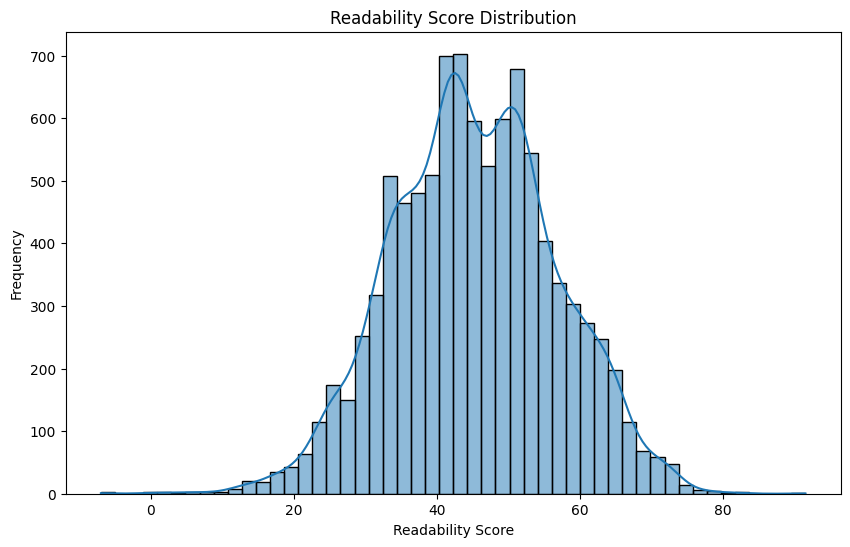

count    9593.000000
mean       45.231187
std        11.444227
min        -6.970000
25%        37.230000
50%        44.950000
75%        52.800000
max        91.510000
Name: readability_score, dtype: float64


In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(data_with_quality["readability_score"], bins=50, kde=True)
plt.title("Readability Score Distribution")
plt.xlabel("Readability Score")
plt.ylabel("Frequency")
plt.show()

print(data_with_quality["readability_score"].describe())

The mean readability score is approximately 45.23. This places the bulk of the dataset in the 40-50 range, which corresponds to moderately complex text.

In [7]:
lowest_readability = data_with_quality.nsmallest(3, 'readability_score')

for idx, row in lowest_readability.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Content: {row['content']}\n")
    print(f"Readability Score: {row['readability_score']}\n")
    print("-" * 80)  # Separator for readability

Title: Job – Geothermal Facilities Engineer, Fervo Energy

Content: ['U.S.-based geothermal developer Fervo Energy is seeking to hire for a position of Geothermal Facilities Engineer.', 'Geothermal developer Fervo Energy has published an open job position, seeking applicants for the position of Geothermal Facilities Engineer. Fervo Energy has developed technology to make geothermal power scalable and cost-effective. Join us and work alongside world-class engineers, researchers, investors, and developers in making geothermal a key pillar of our climate-friendly energy future. Position Description The Geothermal Facilities Engineer will lead the design, development, and construction of surface facilities and transmission interconnections across Fervo’ s portfolio of geothermal energy developments. This person will be responsible for project initiation, assessment, and scoping, budget estimation, execution planning, scheduling, cost monitoring, and construction oversight. The Geothermal F

The output displays the three articles with the lowest readability scores in the dataset. These are characterized by detailed, technical, or verbose content that likely contributed to their extremely low or negative scores:
1. "Job – Geothermal Facilities Engineer, Fervo Energy" has the lowest readability score of -6.97. It is a lengthy job description that includes technical terminology, role requirements, and qualifications, making it highly complex for general readers.
2. "Innovation & Finance in Energy Summit Brings Together Luminaries" has a readability score of -6.29. This article contains a dense list of participants, technical energy-related topics, and formal event descriptions, which likely lowered its readability.
3. "Colombia publishes Geographic Standard for Geothermal Information" has a readability score of -0.6. It is a highly detailed explanation of geothermal standards and regulations in Colombia, including references to specific laws, resolutions, and technical details, which make it challenging to read.

In [8]:
highest_readability = data_with_quality.nlargest(3, 'readability_score')

for idx, row in highest_readability.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Content: {row['content'][:500]}\n")
    print(f"Readability Score: {row['readability_score']}\n")
    print("-" * 80)

Title: The Boy Who Cried Wolf: Redux

Content: ['Once upon a time there was a boy.', 'He was a good boy who wanted only to make his family proud and serve the remote mountain village where he grew up.', 'When the time came to choose a career the boy knew his family was not wealthy enough for him to become a merchant, nor did he much fancy leaving the village to become a soldier. So he approached the local sheep herder and asked if he could train to become a shepherd.', "The shepherd agreed and the boy proved a conscientious pupil, quickly le

Readability Score: 91.51

--------------------------------------------------------------------------------
Title: `` Tesla Drivers Are The Same As Harley Riders ''

Content: ['So asserts John Jensen, who rides a Harley-Davidson Sports Glide and drives a Tesla Model 3 Long Range. Both groups have strong brand loyalty, have their own owner groups, and love to customise. They buy things for their cars that other car owners and bike riders wouldn’ t, 

1. "The Boy Who Cried Wolf: Redux" has the highest readability score of 91.51. It is a simple and engaging retelling of the classic fable, characterized by short sentences, familiar vocabulary, and an accessible narrative style, making it highly readable.
2. "Tesla Drivers Are The Same As Harley Riders" has a readability score of 82.85. The content uses relatable comparisons, humor, and an informal tone to discuss the similarities between Tesla drivers and Harley-Davidson riders, making it enjoyable and easy to follow.
3. "Onewheel — Pragmatic Commuter Tool or The Secret To Eternal Youth?" has a readability score of 81.73. It offers a mix of personal anecdotes, conversational language, and practical insights about the Onewheel device, appealing to a general audience.

We can clearly see that the contents with the highest readability scores are longer texts with simpler words. The highest rated content is a long text that seems to be a story for children.

**Summary**

The readability scores and distribution indicate that the data is moderately to highly complex, which guides us toward:

- Selecting models that can handle technical language (for example SciBERT for embeddings)
- Configuring adaptive chunking, because the lower readability scores imply dense information that may not fit well within small token limits.
- Configuring token limits since a high percentage of the content is challenging to read, standard token limits (like 512 or 1024 tokens) may result in incomplete context. Testing larger token limits or using models that support extended context may be beneficial.
- Handling Complexity in Responses: The generation model should be capable of simplifying dense information for user queries.

#### 2.1.2 Outlier Detection

- **Experiment:** Calculate text length distributions and apply statistical thresholds (for example texts with word counts or token counts outside the 95th percentile) to detect unusually short or long documents.

- **Goal:** Determine an optimal range for token limits, preventing exceedingly short or lengthy content from distorting the embedding and retrieval process.

To perform outlier detection based on text length, we'll calculate the distribution of text lengths (in terms of word counts or token counts) and identify outliers. Detecting unusually short or long entries will help us establish a sensible token limit for chunking, ensuring that we capture coherent context without excessive padding or truncation.

**Step-by-step approach:**
1. Calculate Text Lengths: Measure the length of each text entry in terms of word count or token count.

2. Determine Statistical Thresholds: Calculate the 95th percentile and other relevant statistics to establish cutoff points for unusually long or short entries.

3. Identify Outliers: Flag entries that fall outside the desired range, as these may need different handling during chunking or tokenization.

In [9]:
# Calculate word count for each content entry
data_with_quality['word_count'] = data_with_quality['content'].apply(lambda x: len(x.split()))
print("Word Count Statistics:")
print(data_with_quality['word_count'].describe())

# Define statistical thresholds (e.g., 5th and 95th percentiles)
lower_bound = np.percentile(data_with_quality['word_count'], 5)
upper_bound = np.percentile(data_with_quality['word_count'], 95)

print(f"\n5th Percentile (Lower Bound): {lower_bound}")
print(f"95th Percentile (Upper Bound): {upper_bound}")

Word Count Statistics:
count    9593.000000
mean      782.845408
std       460.126015
min       201.000000
25%       437.000000
50%       668.000000
75%      1012.000000
max      2995.000000
Name: word_count, dtype: float64

5th Percentile (Lower Bound): 272.0
95th Percentile (Upper Bound): 1685.3999999999996


The mean about of words in the contents is 782.

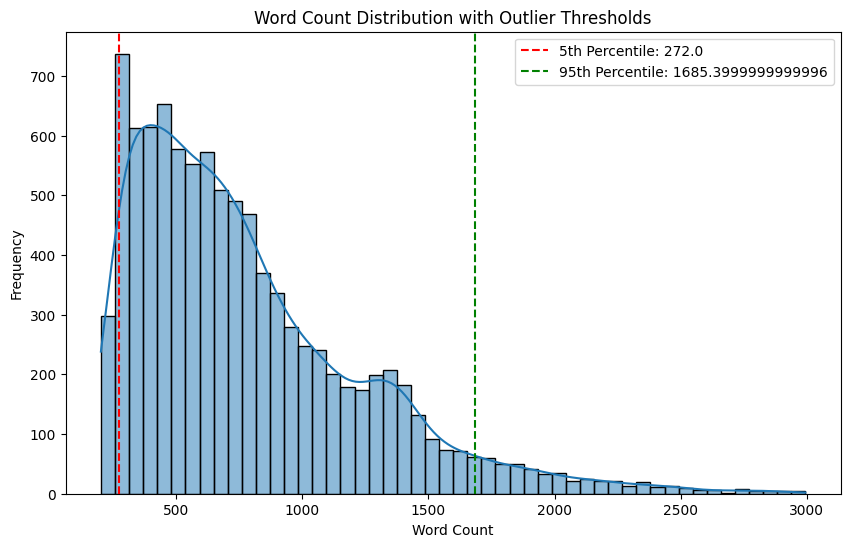

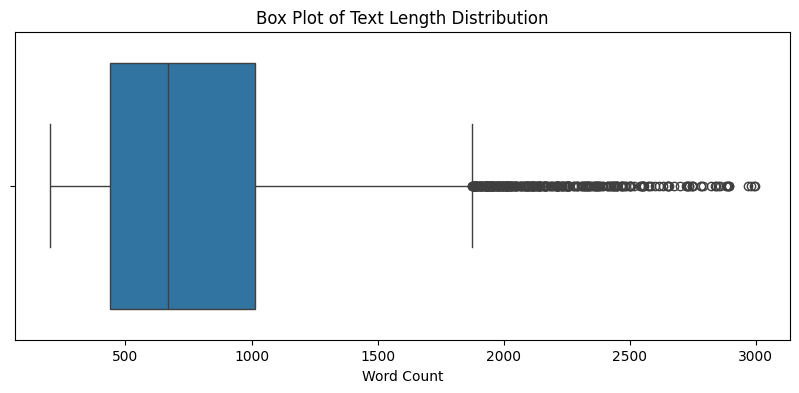

In [10]:
# Identify entries that are outliers
outliers = data_with_quality[(data_with_quality['word_count'] < lower_bound) | 
                             (data_with_quality['word_count'] > upper_bound)]

# Visualize the word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_with_quality['word_count'], bins=50, kde=True)
plt.axvline(lower_bound, color='red', linestyle='--', label=f'5th Percentile: {lower_bound}')
plt.axvline(upper_bound, color='green', linestyle='--', label=f'95th Percentile: {upper_bound}')
plt.title("Word Count Distribution with Outlier Thresholds")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Box plot to show spread and detect outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=data_with_quality['word_count'])
plt.title("Box Plot of Text Length Distribution")
plt.xlabel("Word Count")
plt.show()

In the plot above we can see the distribution of the number of words in the contents. We can see that the vast majority of the contents have less than 1000 words. The distribution is right-skewed, with a long tail of contents with more than 1000 words, ranging all the way to around 2900 words.

Let's see if there are outliers that are domain-dependent.

In [11]:
# Show domains with most rows below 5th percentile in percent of total rows
outliers['domain'].value_counts() / data_with_quality['domain'].value_counts() * 100

domain
azocleantech             10.694530
businessgreen             1.898734
cleantechnica            11.929070
decarbxpo                      NaN
ecofriend                 2.631579
energyintel               9.829060
energyvoice              10.422812
eurosolar                17.857143
greenprophet             10.000000
indorenergy                    NaN
naturalgasintel           5.471125
pv-magazine               6.467662
pv-tech                  23.706897
rechargenews             10.017889
solarindustrymag         13.372957
solarpowerportal.co      11.764706
solarpowerworldonline    10.099010
solarquarter             17.647059
thinkgeoenergy            6.666667
Name: count, dtype: float64

The domains pv-tech (23.71%) and eurosolar (17.86%) have the highest percentage of outliers, indicating a significant proportion of entries with unusual characteristics, such as extreme lengths. Other domains with notable percentages of outliers include cleantechnica (11.93%) and solarpowerportal.co (11.76%). This variability in article length or content complexity suggests that these sources may require specific preprocessing adjustments, such as chunking or normalization, to standardize the dataset and ensure consistency for embedding and retrieval processes.

**Summary**

Based on our findings of this experiment, we can derive the following insights:

- Optimal Token Limits: The 95th percentile serves as a benchmark for setting upper limits on tokenization or chunking. Entries above this threshold may need to be split into multiple chunks or truncated to stay within model token limits.

- Handling Short Entries: Entries below the 5th percentile may require padding or could be excluded from certain analyses if they lack sufficient context, ensuring that only meaningful content is processed.

- Guiding Chunking Strategy: Analyzing typical text lengths enables us to devise chunking strategies (for example sentence-based or paragraph-based) that balance coherence with model token limits, allowing most entries to fit within an optimal range.

Character Count Statistics:
count     9593.000000
mean      4907.448348
std       2834.469909
min       1188.000000
25%       2771.000000
50%       4230.000000
75%       6286.000000
max      19836.000000
Name: char_count, dtype: float64

5th Percentile (Lower Bound): 1726.0
95th Percentile (Upper Bound): 10456.999999999998


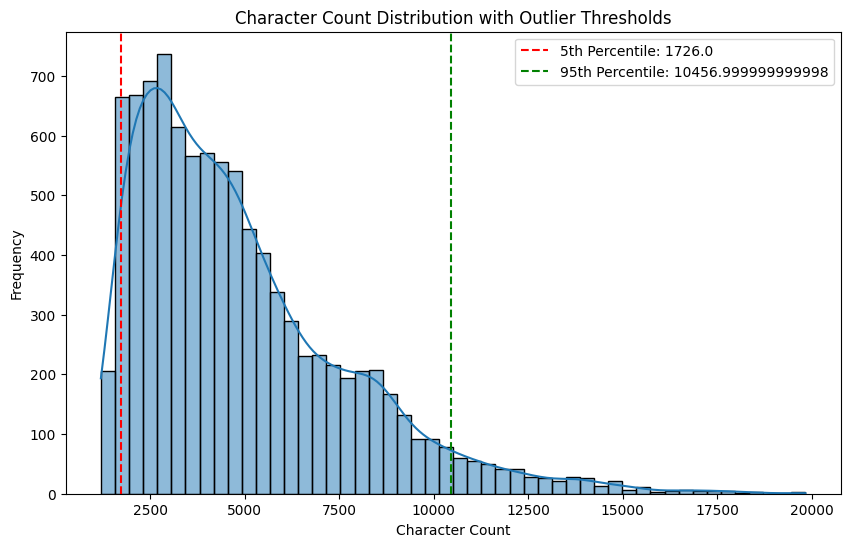

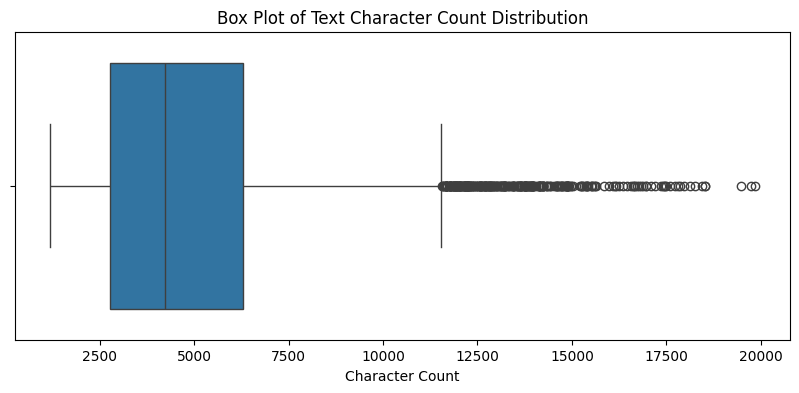

In [12]:
# Calculate character count for each content entry
data_with_quality['char_count'] = data_with_quality['content'].apply(len)
print("Character Count Statistics:")
print(data_with_quality['char_count'].describe())

# Define statistical thresholds (e.g., 5th and 95th percentiles)
char_lower_bound = np.percentile(data_with_quality['char_count'], 5)
char_upper_bound = np.percentile(data_with_quality['char_count'], 95)

print(f"\n5th Percentile (Lower Bound): {char_lower_bound}")
print(f"95th Percentile (Upper Bound): {char_upper_bound}")

# Identify entries that are outliers
char_outliers = data_with_quality[(data_with_quality['char_count'] < char_lower_bound) | 
                                  (data_with_quality['char_count'] > char_upper_bound)]

# Visualize the character count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_with_quality['char_count'], bins=50, kde=True)
plt.axvline(char_lower_bound, color='red', linestyle='--', label=f'5th Percentile: {char_lower_bound}')
plt.axvline(char_upper_bound, color='green', linestyle='--', label=f'95th Percentile: {char_upper_bound}')
plt.title("Character Count Distribution with Outlier Thresholds")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Box plot to show spread and detect outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=data_with_quality['char_count'])
plt.title("Box Plot of Text Character Count Distribution")
plt.xlabel("Character Count")
plt.show()

Observations
- The majority of articles have character counts between 2,000 and 10,000, with the average around 4,907 characters.
- Outlier thresholds are defined as below 1,726 characters (5th percentile) and above 10,457 characters (95th percentile).
- The histogram and box plot reveal several outliers, with some articles exceeding 19,836 characters or being as short as 1,188 characters.
- These outliers may require preprocessing adjustments (e.g., chunking) to ensure uniformity for tasks like embedding and retrieval.

#### 2.1.3 Token Analysis

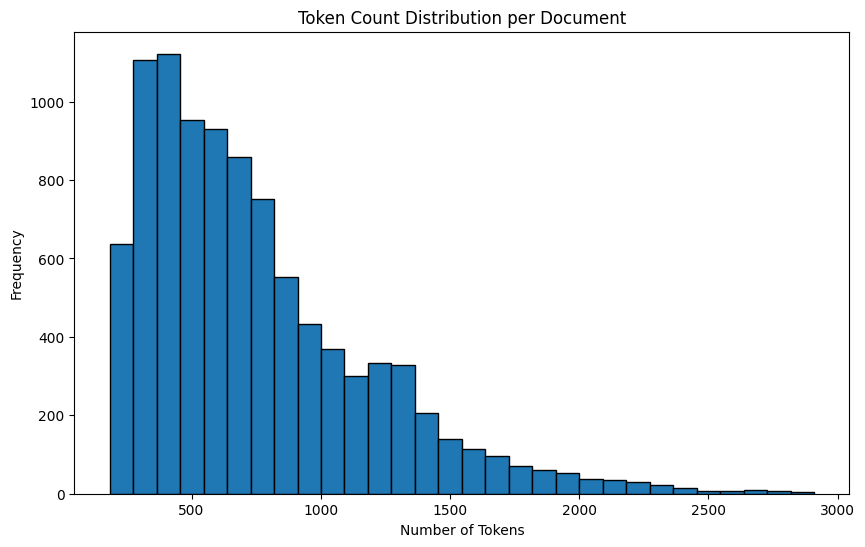

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer to count words (tokens)
vectorizer = CountVectorizer()

# Fit the vectorizer on the text data and transform it into token counts
X = vectorizer.fit_transform(data['content'])

# Sum up the token counts for each document
data['token_count'] = X.sum(axis=1).A1  # Convert to a flat array

# Plot the token count distribution
plt.figure(figsize=(10, 6))
plt.hist(data['token_count'], bins=30, edgecolor='black')
plt.title("Token Count Distribution per Document")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

The histogram shows the distribution of token counts per document. Most documents have token counts clustered around 200-800, indicating that the majority of documents are relatively short. There’s a long tail extending to around 2,500 tokens, which suggests that a small number of documents are much longer than the average.

This distribution implies that the majority of documents will fit well within standard token limits for most embedding models, but some longer documents may require chunking to be processed effectively in a Retrieval-Augmented Generation (RAG) pipeline.

This token distribution helps optimize the RAG system by:

1. **Setting Chunk Sizes**: Most documents are 200-800 tokens, so we can set chunk sizes within this range to avoid over-chunking short documents and ensure context retention in longer ones.

2. **Embedding Efficiency**: Knowing the distribution helps us focus embedding resources on larger documents, while skipping unnecessary chunking for shorter ones.

3. **Preventing Truncation**: Tailoring chunk and overlap settings based on token limits ensures no information is lost during retrieval and answer generation.

4. **Resource Planning**: With most documents short, we can allocate more resources strategically for longer texts in storage and processing.

### 2.2 Building Data Understanding

Understanding the distribution and structure of the data is essential for optimizing chunking, tokenization, and embedding. By analyzing factors such as language style, terminology and length, we can select an embedding model and chunking strategy that best aligns with the content's characteristics.

#### 2.2.1 Defining Optimal Chunk Size Based on Text Length Distribution

- **Experiment:** Use the previously calculated 5th and 95th percentiles from text length analysis to guide the definition of chunk sizes. Entries above the 95th percentile will be split into manageable chunks, while entries below the 5th percentile may require padding or grouping to maintain meaningful context.

- **Goal:** Establish an optimal chunk size range that maximizes context coherence while staying within the model's token limits, thereby ensuring consistent embedding quality and retrieval accuracy.

In [14]:
# Set chunk size limits based on the 5th and 95th percentile word counts
lower_chunk_limit = int(np.percentile(data_with_quality['word_count'], 5))
upper_chunk_limit = int(np.percentile(data_with_quality['word_count'], 95))

print(f"Recommended Chunk Size Range: {lower_chunk_limit} - {upper_chunk_limit} words")

# Define a function to chunk longer texts
def chunk_text(text, max_words=upper_chunk_limit):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunk = ' '.join(words[i:i + max_words])
        chunks.append(chunk)
    return chunks

# Apply chunking to entries exceeding the upper chunk limit
data_with_quality['content_chunks'] = data_with_quality['content'].apply(
    lambda x: chunk_text(x) if len(x.split()) > upper_chunk_limit else [x]
)

Recommended Chunk Size Range: 272 - 1685 words


The output defines the recommended chunk size range (272 to 1685 words) based on the 5th and 95th percentiles of word counts, ensuring optimal text segmentation for processing.

How chunking works: For instance, if the upper_chunk_limit is set to 100 words, and a piece of content has 250 words, it will be split into three chunks:
- Chunk 1: Words 1–100
- Chunk 2: Words 101–200
- Chunk 3: Words 201–250

To inspect the chunks effectively, let's print out the actual contents of the `content_chunks` column for entries that exceed the `upper_chunk_limit`. We'll look specifically at examples where the content was split, so you can see the chunks as they appear in the data.

In [15]:
for index, row in data_with_quality.iterrows():
    if len(row['content_chunks']) > 1:  # Check if the content was chunked
        print(f"Title: {row['title']}")
        for i, chunk in enumerate(row['content_chunks']):
            print(f"  Chunk {i+1}:\n{chunk[:500]}...\n")
        print("-" * 80)  # Separator for clarity

Title: Capturing the Moment: Carbon Capture in the American Jobs Plan
  Chunk 1:
['President Biden’ s $ 2.25 trillion-plus American Jobs Plan ( AJP) contains various incentives and investments to deploy carbon capture technology in the US. Carbon capture is one of many key technologies that need to be deployed at scale to decarbonize the US economy. Significant investments this decade have the potential to catapult the carbon management industry into the mainstream. In this note, we unpack the carbon capture relevant components of the AJP and, where possible, we quantify the...

  Chunk 2:
enhancements also leads to jobs. Carbon capture projects require engineers, construction workers, pipefitters, and other specialized labor. They also require steel, concrete, and other construction materials and equipment. Once built, carbon capture facilities require additional people to operate the machinery and manufacture replacement parts. To examine the economic effects of the AJP, we employ a 

#### 2.2.2 Content Type Consistency (Domain-Specific Terminology)

Given our goal to ensure semantic alignment within a specific domain, we’ll concentrate on verifying the presence of relevant terminology across the dataset.

Entries lacking domain-specific terms can be reviewed to determine if they are relevant to the dataset's focus. For instance, articles without terms like "solar," "emission," or "energy" in an energy-focused dataset may require further inspection.

In [16]:
# Define a list of domain-specific keywords
domain_terms = ["renewable", "solar", "carbon", "emission", "climate", "energy", "sustainable", "electric"]

# Initialize a column to indicate the presence of domain-specific terms
data_with_quality['domain_specific'] = data_with_quality['content'].apply(
    lambda content: any(term in content.lower() for term in domain_terms)
)

# Count entries with and without domain-specific terms
domain_consistent_count = data_with_quality['domain_specific'].sum()
non_domain_consistent_count = len(data_with_quality) - domain_consistent_count

print(f"Entries with domain-specific terminology: {domain_consistent_count}")
print(f"Entries lacking domain-specific terminology: {non_domain_consistent_count}")

# Sample entries lacking domain-specific terminology
print("\nSample Entries Missing Domain Terminology:")
data_with_quality[data_with_quality['domain_specific'] == False][['title', 'content']].head(10)

Entries with domain-specific terminology: 9508
Entries lacking domain-specific terminology: 85

Sample Entries Missing Domain Terminology:


,title,content
74,Chevron Lines Up US Gulf Wildcat Near Puma West,"[""Chevron has moved quickly to permit a new ex..."
237,LNG Canada plans return after COVID-19 outbrea...,['Staffing levels are increasing at LNG Canada...
244,"Energean takes FID on Karish North, signs new ...",['Energean has taken final investment decision...
256,Tullow production to fall in 2021 - News for t...,['Tullow Oil expects production to continue de...
272,Eskom wastes millions on failed housing plan a...,['The South African government plans to invest...
293,New tax rules aim to end 'big debate ' on UK d...,['New changes for decommissioning tax rules wi...
300,IR35: What next for the PSC 'one-man company '...,['For many years in the North East of Scotland...
333,Petroleum ministry tells India’ s ONGC to sell...,['The Indian Ministry of Petroleum and Natural...
349,Niger-Benin pipeline ceremony due May 20 - New...,['Benin plans to officially begin work on a cr...
350,OWGP frees up £4.2m to support UK offshore win...,['The Offshore Wind Growth Partnership ( OWGP)...


It shows that 9508 entries contain domain-specific terminology, while 85 entries do not. This indicates that the majority of the dataset is aligned with energy-related topics, while a small subset may lack relevance or require further review. A sample of 10 entries missing domain-specific terms is displayed for further inspection and validation of their content.

In [17]:
print(data_with_quality[data_with_quality['domain_specific'] == False])

                                                  title        date  \
74      Chevron Lines Up US Gulf Wildcat Near Puma West  2021-08-17   
237   LNG Canada plans return after COVID-19 outbrea...  2021-01-11   
244   Energean takes FID on Karish North, signs new ...  2021-01-14   
256   Tullow production to fall in 2021 - News for t...  2021-01-27   
272   Eskom wastes millions on failed housing plan a...  2021-02-10   
...                                                 ...         ...   
5580    Is laundry fuelling the marine plastics crisis?  2021-01-13   
5685  BusinessGreen Technology and Investment Forum ...  2021-04-08   
6575  Eavor completes Eavor-Deep geothermal demonstr...  2023-01-31   
7061  GCL note holders formally approve debt restruc...  2021-06-07   
7944  VoltStorage unveils vanadium redox flow batter...  2023-07-12   

         author                                            content  \
74          NaN  ["Chevron has moved quickly to permit a new ex...   
237    

85 entries identified as lacking domain-specific terminology, with details such as title, content, domain, and additional metadata. These entries span various topics and domains, suggesting that they may either be tangentially related to the energy sector or require further review. Examples include articles discussing corporate updates, financial restructuring, and broader environmental topics without clear references to key domain terms.

In [18]:
import tiktoken

def num_tokens_from_text(text: str, encoding_name="cl100k_base"):
    """
    Returns the number of tokens in a text string.
    """
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(text))
    return num_tokens

data_with_quality["num_tokens"] = data_with_quality["content"].apply(num_tokens_from_text)

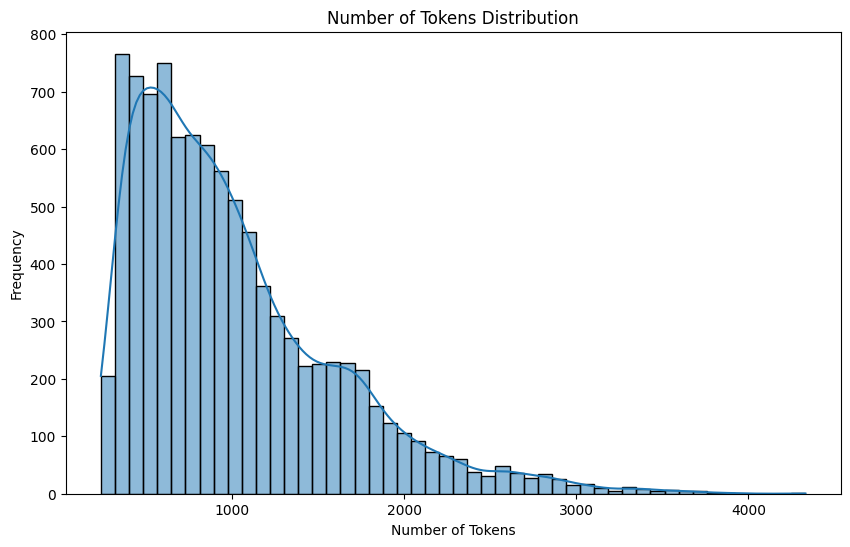

In [19]:
# plot the distribution of the number of tokens
plt.figure(figsize=(10, 6))
sns.histplot(data_with_quality["num_tokens"], bins=50, kde=True)
plt.title("Number of Tokens Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

The histogram visualizes the distribution of the number of tokens across the dataset. The majority of entries have a token count between 500 and 1500, with a gradual decline beyond this range.A smaller number of articles exceed 4000 tokens, indicating a few exceptionally long entries.

#### 2.2.3 Relationship Between Variables

Explore relationships between variables, such as how sentiment scores correlate with content length or publication dates.

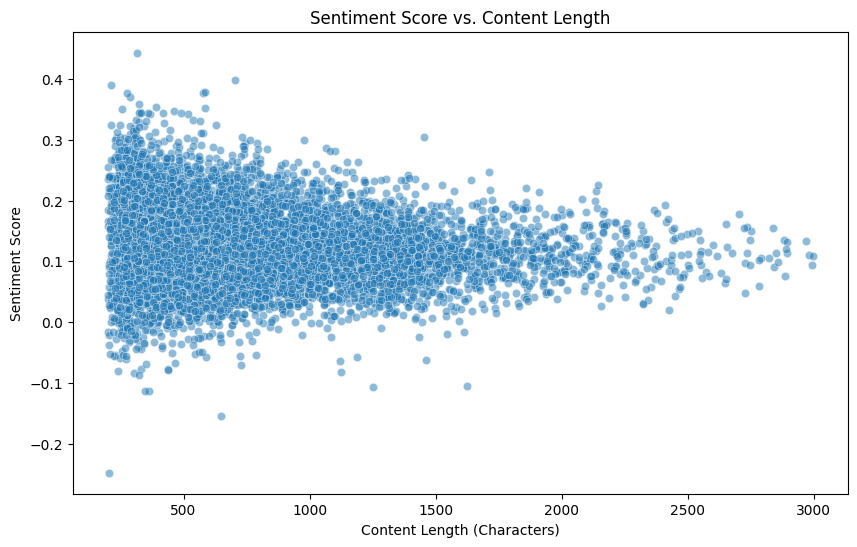

In [27]:
# Scatter plot of sentiment score vs. content length
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='sentiment', data=data_with_quality, alpha=0.5)
plt.title('Sentiment Score vs. Content Length')
plt.xlabel('Content Length (Characters)')
plt.ylabel('Sentiment Score')
plt.show()

Observations
- Most entries cluster around neutral to slightly positive sentiment scores (0 to 0.2), regardless of content length.
- No clear correlation is observed between sentiment score and content length, indicating that text length does not significantly affect sentiment polarity.
- A small number of entries exhibit negative sentiment, but these are sparse and distributed across different content lengths.

#### 2.2.4 Articles per Domain

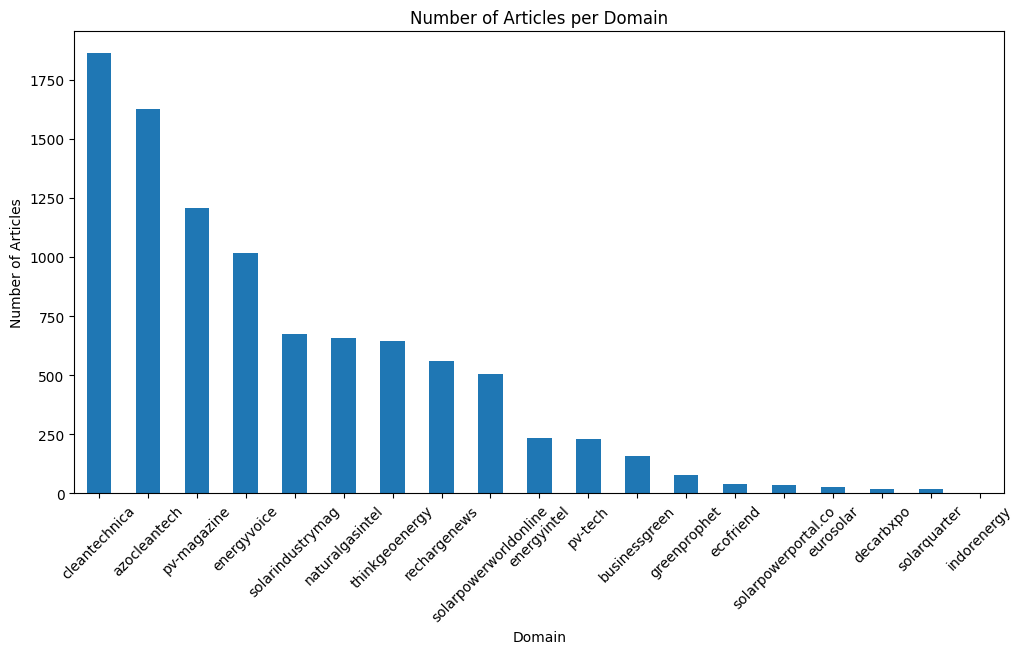

In [28]:
domain_counts = data['domain'].value_counts()

plt.figure(figsize=(12, 6))
domain_counts.plot(kind='bar')
plt.title('Number of Articles per Domain')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

Observations
- "cleantechnica" has the highest number of articles, followed by "azocleantech" and "pv-magazine."
- Domains like "indorenergy" and "solarquarter" have the fewest articles, indicating limited representation.
- The chart highlights the uneven distribution of articles across domains, with a few domains contributing significantly more content than others.

#### 2.2.5 Word Analysis

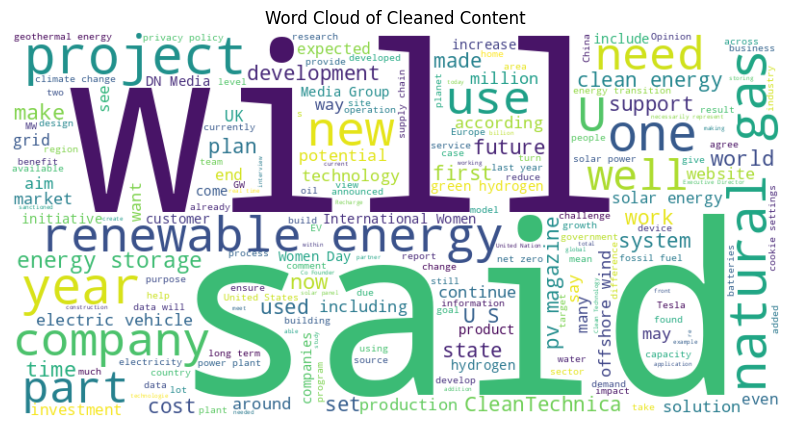

In [29]:
from wordcloud import WordCloud

# Combine all cleaned content into a single string
text = ' '.join(data['content'].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Cleaned Content')
plt.show()

The word cloud highlights the central themes in the dataset, with terms like **"energy," "renewable,"** and **"natural gas"** being the most prominent. This indicates a strong focus on energy-related topics, particularly renewable energy initiatives. Other significant words, such as **"project"** and **"said,"** suggest frequent discussions around specific projects and stakeholder commentary. The presence of terms like **"electric vehicle"** and **"solar"** points to technological innovations in the cleantech sector. Overall, the word cloud reveals key areas of interest and current trends within the energy landscape, emphasizing the dataset's relevance to ongoing discussions in the field.

N-gram analysis is a useful technique for examining the frequency of contiguous sequences of words (or characters) in a text corpus.

<Figure size 1200x600 with 0 Axes>

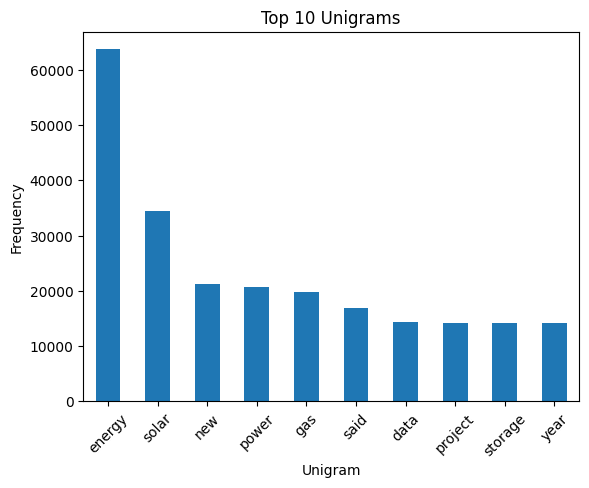

<Figure size 1200x600 with 0 Axes>

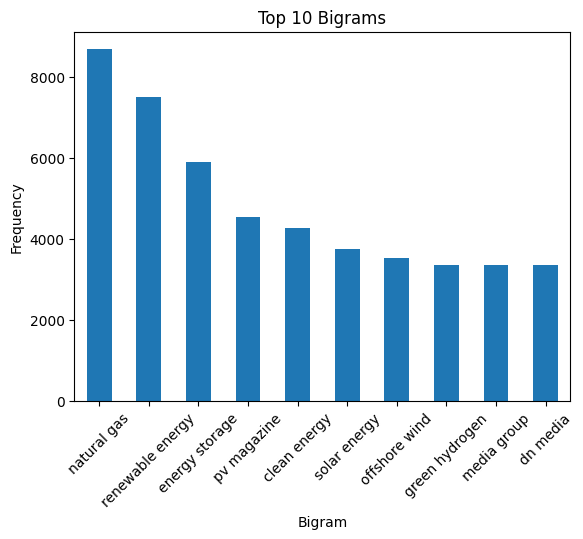

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

def generate_ngrams(data, n):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(data['content'])
    ngram_freq = ngrams.sum(axis=0)
    ngrams_df = pd.DataFrame(ngram_freq, columns=vectorizer.get_feature_names_out())
    return ngrams_df.T.sort_values(by=0, ascending=False)

unigrams = generate_ngrams(data, 1)
bigrams = generate_ngrams(data, 2)

plt.figure(figsize=(12, 6))
unigrams.head(10).plot(kind='bar', legend=False)
plt.title('Top 10 Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
bigrams.head(10).plot(kind='bar', legend=False)
plt.title('Top 10 Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Observations
- The most frequent unigram is "energy," followed by "solar," reflecting the dataset's primary focus on renewable energy.
- Other high-frequency unigrams include "new," "power," "gas," and "project," emphasizing discussions around energy projects and technologies.

### 2.3 Sentiment Analysis

The goal of this step is to quantify the sentiment expressed in the text data, providing a numerical value that reflects whether the sentiment is positive, negative, or neutral (-1.0 indicates a negative sentiment, 1.0 indicates a positive sentiment, and 0 indicates a neutral sentiment).

**Example**

For instance, if content_cleaned has an entry like "This technology is amazing!", the get_sentiment function would return a positive polarity score (e.g., 0.8). Conversely, if the entry is "This technology is terrible!", it might return a negative polarity score (e.g., -0.7). This transformation allows for quantifying and analyzing sentiments in the dataset systematically.

In [23]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the 'content' column
data_with_quality['sentiment'] = data_with_quality['content'].apply(get_sentiment)
print(data_with_quality['sentiment'].describe())

count    9593.000000
mean        0.124929
std         0.061749
min        -0.247789
25%         0.084180
50%         0.120353
75%         0.161834
max         0.443182
Name: sentiment, dtype: float64


Observations
- Mean sentiment polarity: 0.125, indicating a slightly positive tone on average.
- Sentiment values range from -0.248 (most negative) to 0.443 (most positive).
- The interquartile range (25th to 75th percentile) shows sentiment values clustering between 0.084 and 0.162.

We can now visualize the sentiment values to help us understand their distribution visually.

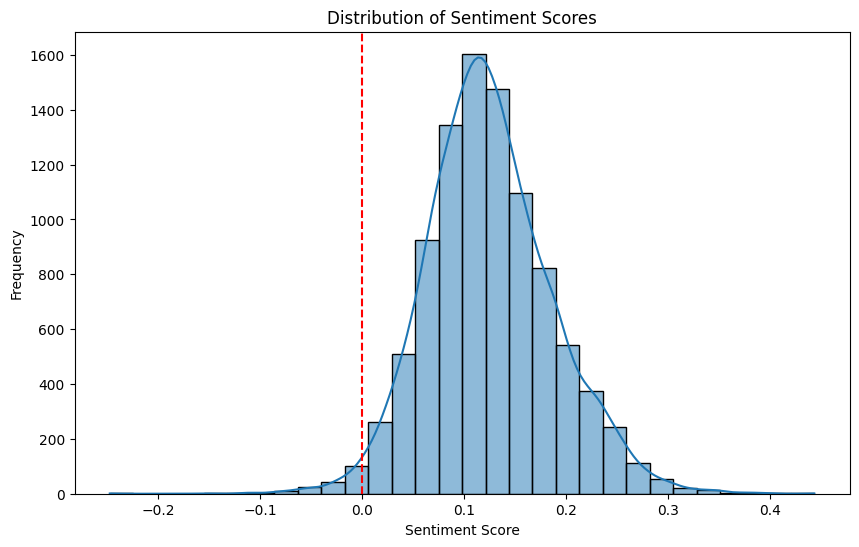

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data_with_quality['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')  # Indicate neutral sentiment
plt.show()

This histogram shows how many entries have positive, negative or neutral sentiments. The red line indicates the neutral sentiment threshold (0). The histogram looks like a normal distribution, with the mean value being around 0.1. 

We can now count how many entries are positive, negative or neutral based on the sentiment scores.

In [25]:
# Classify sentiment
data_with_quality['sentiment_category'] = pd.cut(data_with_quality['sentiment'], bins=[-1, -0.1, 0.1, 1], labels=['Negative', 'Neutral', 'Positive'])

# Count the occurrences of each sentiment category
sentiment_counts = data_with_quality['sentiment_category'].value_counts()
print(sentiment_counts)

sentiment_category
Positive    6232
Neutral     3355
Negative       6
Name: count, dtype: int64


Observations
- Positive: 6,232 articles (~65% of the dataset), indicating a predominantly positive tone.
- Neutral: 3,355 articles (~35% of the dataset), showing a significant number of articles with balanced or neutral sentiment.
- Negative: Only 6 articles (~0.06%), suggesting very few entries exhibit a strongly negative tone.

### 2.4 Text Summarization

Types of Text Summarization:
- Extractive Summarization: This method selects key sentences or phrases directly from the text to create a summary. It aims to retain important information without altering the original wording. Techniques often include sentence ranking based on features like term frequency, sentence position, or using models like TF-IDF.
- Abstractive Summarization: This approach generates new sentences to convey the main ideas of the text. It requires a deeper understanding of the content and may involve techniques such as paraphrasing and generating new phrases. Models like T5, BART, or GPT are commonly used for this purpose.

In [26]:
from transformers import pipeline

# Load the summarization model
summarizer = pipeline("summarization")

def summarize_text(text):
    summary = summarizer(text, max_length=130, min_length=30, do_sample=False)
    return summary[0]['summary_text']

data_sample = data_with_quality["content"].head()

for text in data_sample:
    print(summarize_text(text) + "\n" + "-" * 80)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


 Qatar Petroleum targeting aggressive cuts in greenhouse gas emissions as it prepares to launch Phase 2 of its planned 48 million ton per year LNG expansion . The company also plans to build some 1.6 gigawatts of solar energy capacity by 2025, half of which should come from the Siraj solar power project next year .
--------------------------------------------------------------------------------
 Kakrapar-3 is the first of India's 700 megawatt indigenously developed pressurized heavy water reactors to reach this milestone . 15 more units of the same design will follow . Fluor and its NuScale subsidiary have launched a play for the UK market via a memorandum of understanding with start-up clean energy firm Shearwater Energy .
--------------------------------------------------------------------------------
 Energy has come to play a bigger role in that relationship than ever before, and rising Chinese imports of US oil and LNG could serve as the foundation for fresh discussions on trade .

These summaries offer a quick yet comprehensive overview of the main points from each article, demonstrating the summarization model's utility.

In [169]:
def summarize_text(text):
    summary = summarizer(text, max_length=130, min_length=30, do_sample=False)
    return summary[0]['summary_text']

data_sample = data_with_quality["content"].head()

for text in data_sample:
    print(summarize_text(text) + "\n" + "-" * 80)

 Qatar Petroleum (QP) is targeting aggressive cuts in its greenhouse gas emissions as it prepares to launch Phase 2 of its planned 48 million ton per year LNG expansion . The company is also aiming to reduce gas flaring intensity across its upstream facilities by more than 75% and has raised its carbon capture and storage ambitions from 5 million tons/yr to 7 million tons by 2027 .
--------------------------------------------------------------------------------
 Kakrapar 3 is the first of India's 700 megawatt pressurized heavy water reactors to reach this milestone . 15 more units of the same design will follow . Fluor and its NuScale project has moved into its second phase . NuScale has launched a play for the UK market via a memorandum of understanding with start up clean energy firm Shearwater Energy to explore the deployment of hybrid SMR and wind energy projects .
--------------------------------------------------------------------------------
 New US President Joe Biden took offi

## 3. Conclusion

Here are the key findings and their implications:

1. **Domain Distribution**:
   - Articles are unevenly distributed across domains, with some sources like *cleantechnica* and *azocleantech* contributing significantly more content than others. This suggests the need to account for domain bias during modeling and analysis.

2. **Content Length**:
   - Content lengths vary widely, with most articles falling within 2,000 to 10,000 characters. Outliers may require normalization, such as chunking, to ensure consistent processing and input for models.

3. **Keyword and Term Analysis**:
   - Frequent unigrams and word cloud analysis confirmed a strong focus on "energy," "solar," and "renewable" topics. The dominance of such terms highlights the dataset's alignment with energy and sustainability themes.

4. **Sentiment Analysis**:
   - The sentiment distribution revealed that most articles exhibit neutral to positive sentiment, with very few showing strong negativity. This indicates a generally optimistic or factual tone in the dataset.

5. **Text Summarization**:
   - Summarization successfully condensed articles into concise and informative representations, highlighting the dataset's potential for abstractive summarization tasks.

6. **Token and Character Distribution**:
   - The analysis of tokens and character counts illustrated variability in text complexity and length, which can influence downstream tasks like embeddings or model training.

7. **Challenges and Opportunities**:
   - Articles lacking domain-specific terms (~0.9%) may need further evaluation for relevance. These entries could either be noise or offer diverse perspectives.
   - Uneven domain representation and varying content complexity emphasize the need for preprocessing and normalization to improve model generalization.

**Overall Implications**

The EDA establishes a strong understanding of the dataset's structure, focus areas, and challenges. These insights will be crucial for designing preprocessing pipelines, identifying modeling priorities, and ensuring the dataset's alignment with the project's goals, such as building a robust multimodal retrieval-augmented generation system.